### -- GLOBAL IMPORTS --

Is it possible to manage multiple labels per image with file/folder?
- Likely not worth it, since an explicity SIMPLE CSV list is easy to check  
- vs a more COMPLEX file/folder naming convention  
- (experience from managing Pokemon assets lol)

In [32]:
from fastai.vision.utils import untar_data, URLs
# PASCAL dataset can have more than one label per image
path = untar_data(URLs.PASCAL_2007)

In [33]:
import pandas as pd

# uses CVS file to get the meta info for :  
# - labels per image 
# - as opposed to deciphering from implicit folder and file name conventions
df = pd.read_csv(path/'train.csv')
# Inspect the first 5 rows of the DataFrame using the head() method
# - The head() function is a convenience method for pandas DataFrame that allows  
#   quick preview the first N rows of your DataFrame : default is 5
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


#### PANDAS and DATAFRAMES - (scratchpad)

- Pandas is a Python library to edit and analyze tabular and time series data
- DataFrames are a table of rows and columns : the main data structure in Pandas

In [34]:
# Trailing :s are optional (in numpy, pytorch, pandas, etc)
# so both of these first row variants work
# first_row = df.iloc[0,:]
first_row = df.iloc[0]
first_column = df.iloc[:, 0]
print(f'--[first_row]--\n{first_row}\n--[first_column]--\n{first_column}')

# can also index by column name
fname_column = df['fname']
#print(f'--[fname_column]--\n{fname_column}')


--[first_row]--
fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object
--[first_column]--
0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object


#### FASTAI : DataBlock (scratchpad)

Explain how DataFrame separates a train and valid set

- DataFrame DOES NOT! it's just a table of rows and columns ... but
- DataBlock does

By default DataBlock is RANDOMLY split to : 

- 80% training set and  
- 20% validation set

In [35]:
from fastai.vision.data import DataBlock

# Example : Create new columns and use them to do calculations
# @note : building a DataFrame == building a table of 2D rows and columns
df1 = pd.DataFrame()
df1['a'] = [1,2,3, 4]
df1['b'] = [10, 20, 30, 40]
sum_column = df1['a'] + df1['b']
print(f'--[a_column]--\n{df1["a"]}\n--[b_column]--\n{df1["b"]}\n--[sum_column]--\n{sum_column}')


dblock = DataBlock()
# loading our df DataFrame into a DataBlock
dsets = dblock.datasets(df1)
dsets.train[0]

# Use 'is_valid' column to specify a custom split and pass to splitter func
#dsets.valid[0]

--[a_column]--
0    1
1    2
2    3
3    4
Name: a, dtype: int64
--[b_column]--
0    10
1    20
2    30
3    40
Name: b, dtype: int64
--[sum_column]--
0    11
1    22
2    33
3    44
dtype: int64


(a     2
 b    20
 Name: 1, dtype: int64,
 a     2
 b    20
 Name: 1, dtype: int64)

#### -- DATABLOCK : load from DataFrame

In [36]:
dblock = DataBlock()
dsets = dblock.datasets(df)

# @note : DataFrame is returned TWICE because the DataBlock assumes :
# - input
# - target
print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')


--[train]--
(fname       004779.jpg
labels      car person
is_valid         False
Name: 2391, dtype: object, fname       004779.jpg
labels      car person
is_valid         False
Name: 2391, dtype: object)
--[valid]--
(fname               002545.jpg
labels      person bottle sofa
is_valid                 False
Name: 1276, dtype: object, fname               002545.jpg
labels      person bottle sofa
is_valid                 False
Name: 1276, dtype: object)


In [6]:
# Explicitly use these inline categories from our DataFrame :
# - 'fname' the image file name
# - 'labels' the list of labels
def get_image_path(row):
    # we actually need the path name to open the image
    return path/'train'/row['fname']
# - 'labels' the list of labels
def get_labels(row):
    # we actually need to split the labels on spaces
    return row['labels'].split(' ')

dblock=DataBlock(get_x=get_image_path, get_y=get_labels)
dsets=dblock.datasets(df)

print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')

--[train]--
(Path('/Users/mton/.fastai/data/pascal_2007/train/003236.jpg'), ['person', 'sofa'])
--[valid]--
(Path('/Users/mton/.fastai/data/pascal_2007/train/001170.jpg'), ['person', 'sofa'])


In [7]:
# lambda is a keyword shortcut for defining an anonymous function inline
# however they aren't compatible with serialization (saving and loading)
# i.e. if you want to export your Learner after training you can't use lambda
# Lambda are not serializable because:
# - they are anonymous and not bound to a name or object in memory
# - lambda functions are also stateless and have no environment/context ...
#   storing and retrieving the state of a lambda function is not possible
'''
dblock = DataBlock(get_x=lambda r:r['fname'], get_y=lambda r:r['labels'])
dsets = dblock.datasets(df)
'''

"\ndblock = DataBlock(get_x=lambda r:r['fname'], get_y=lambda r:r['labels'])\ndsets = dblock.datasets(df)\n"

--- MULTICATEGORY ---

In [8]:
from fastai.vision.data import ImageBlock, MultiCategoryBlock

# @note open the images and convert to tensors
dblock = DataBlock(
    # ImageBlock works fine because we have a file path
    # But... MultiCategoryBlock is needed because we have multiple labels
    # @audit-ok 🔎 : MultiCategoryBlocks is a list of strings (why not list of ints?)
    # as opposed to CategoryBlock's single int
    blocks=(ImageBlock, MultiCategoryBlock), # type:ignore
    get_x=get_image_path,
    get_y=get_labels)

dsets = dblock.datasets(df)
# unlike with CategoryBlock where a single int is returned, 
# MultiCategoryBlock returns a list of labels
# We have a list of 0s, with a 1 where a category is present
# @audit-ok ☑: Explain what is one-hot encoding?
# Answer : https://en.wikipedia.org/wiki/One-hot
# In digital circuits and machine learning, a one-hot is a group of bits among 
# which the legal combinations of values are only those with a 
# single high (1) bit and all the others low (0).[1] A similar implementation 
# in which all bits are '1' except one '0' is sometimes called one-cold
# @audit-ok ☑ : Explain how is the list of 0s and 1s created?  How is the 
# length determined?
# Answer : The LENGTH of the list is determined by the number of CATEGORIES
# in the dataset, and the 1s are placed in the INDEX of the category
# - if an image's TensorMultiCategory has a 1 in index [0] AND index [2]
# - and the vocab are ['cat', 'dog', 'bird', 'bee']
# - then the image label has both 'cat' and 'bird'
# @note "vocab" is one-hot encoded because Pytorch requires tensors to be 
# uniform size/length

print(f'--[vocab]--(size :{len(dsets.train.vocab)})\n{dsets.train.vocab}\n')
print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')
print(f'--[train {len(dsets.train.vocab)}]--\n{dsets.train.vocab}\n--[valid {len(dsets.valid.vocab)}]--\n{dsets.valid.vocab}')

--[vocab]--(size :20)
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

--[train]--
(PILImage mode=RGB size=228x500, TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 0.]))
--[valid]--
(PILImage mode=RGB size=361x500, TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                     0., 0., 0., 0., 0.]))
--[train 20]--
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
--[valid 20]--
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [9]:
import torch

# idxs = indexes where the value is 1.0
idxs = torch.where(dsets.train[0][1]==1.0)[0] # type: ignore
idx_to_labels = dsets.train.vocab[idxs]
# @audit-ok 🔎 : Is there a way to log the image name/path from PILImage?
print(f'--[idx_to_labels]--\n{idx_to_labels} dsets.train[0] {dsets.train[0][0]}')

--[idx_to_labels]--
['bottle'] dsets.train[0] PILImage mode=RGB size=228x500


--- TRAIN AND VALIDATION SPLIT ---

In [10]:
def splitter(dataformat):
    "splits the set into train or valid based on the 'is_valid' column"
    # ~ is the bitwise NOT operator, it flips all the bits
    # so ~True == False and ~False == True
    # @audit-ok 🔎 : logical NOT operator is ! why can't we use it here?
    # Getting an expected expression error when trying to use ! operator
    # train = dataformat.index[!dataformat['is_valid']].tolist()
    train = dataformat.index[~dataformat['is_valid']].tolist()
    valid = dataformat.index[dataformat['is_valid']].tolist()
    return train, valid

# Use manual splitter instead of letting DataBlock default to random split
dblock = DataBlock(
    # ImageBlock is the independent (x) variable and 
    # MultiCategoryBlock is the dependent (y) variable
    blocks = (ImageBlock, MultiCategoryBlock), # type:ignore
    splitter = splitter, # split based on is_valid column
    get_x = get_image_path,
    get_y = get_labels
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

--- IMAGE DATA AUGMENTATION ---

In [11]:
from fastai.vision.augment import RandomResizedCrop

dblock = DataBlock(
    # ImageBlock is the independent (x) variable and 
    # MultiCategoryBlock is the dependent (y) variable
    blocks = (ImageBlock, MultiCategoryBlock), # type:ignore
    splitter = splitter,
    get_x = get_image_path,
    get_y = get_labels,
    # NOTE : ensure every image is the same size
    item_tfms = RandomResizedCrop(128, min_scale=0.35) # type:ignore
)

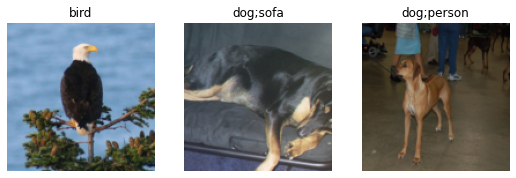

In [12]:
dls = dblock.dataloaders(df)
# @audit-ok ☑ : If anything goes wrong use "summary" method from previous lesson : HOW?
# ANSWER : dls.summary()
dls.show_batch(nrows=1, ncols=3)

--- LEARNERS ---

Chapter 4 showed that a learner needs 4 main things :
- model : we'll leverage fastai's resnet18, class inheriting from nn.Module
- optimizer : fastai will use SGD by default
- DatLoaders object
- loss function ... let's FOCUS on ensuring we have a suitable loss function

In [13]:
# @audit-issue ❌ : fastai.vision.learner FAILS, use fastai.vision.all instead
from fastai.vision.all import vision_learner, cnn_learner
from fastai.vision.models import resnet18

#learn = vision_learner(dls, resnet18)
# @audit 🛑 : using cnn_learner for book example
# @todo : reimplement using vision_learner 
# @audit 🤖 : in a future lesson we will implement our own resnet model
learn = cnn_learner(dls, resnet18)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Debug by manually getting a mini-batch
# - pass it into the model
# - logg activations and loss
x,y = dls.train.one_batch()
activs = learn.model(x)
# activs have a shape of batch_size 64 and prob of 20 categories because :
# - 20 categories because we have 20 label vocabulary in our dataset
# - @audit-ok 🔎 : Explain why we have a 64 batch size
print(f'--[activs.shape]--(batch [64], categories [20])--\n{activs.shape}\n--[model activations]--(activs[0])--\n{activs[0]}')

--[activs.shape]--(batch [64], categories [20])--
torch.Size([64, 20])
--[model activations]--(activs[0])--
TensorBase([ 3.4062, -1.4348, -0.8527,  2.1588, -0.2528,  0.2486, -2.3841,
             5.3187,  0.1569,  0.6035, -5.2146, -4.2757,  1.6595,  0.1789,
             0.2884,  2.4764,  4.7424, -1.8039,  0.2510,  1.4063],
           grad_fn=<AliasBackward0>)


--- BINARY CROSS ENTROPY ---

 BINARY CROSS ENTROPY loss works for multi-label classification because :
 - each activation is compared against each target for each column
 - matches one-hot encoding of each label orthogonal to each other
 - NOTE : one-hot encoding is list of zero where we switch to 1 for each label
   one-cold encodling is a list of ones where we switch to 0 for each label
 - supports outputs to be NONE, SINGLE or MULTIPE labels by entirely using
 - NOTE : MNIST_LOSS (and log) along with Pytorch's MAGIC element-wise operations

Why can't we use SOFTMAX or NLL_LOSS instead of BINARY_CROSS_ENTROPY:
 - SOFTMAX pushes sum to 1.0, so doesn't support none or multiple label outputs
 - NLL_LOSS returns the value of just one activation

In [15]:
# @audit-ok 🔎 : confirm that one-hot-encoding is effectively enum bit flags?
def binary_cross_entropy(inputs, targets):
    # NOTE : NICE!! this string message shows up as function documentation
    "Uses Pytorch's MAGIC element-wise operations to one-hot encode targets"

    # @audit-ok 🔎 : Explain why we need sigmoid here?
    inputs = inputs.sigmoid()
    # @audit-ok 🔎 : Explain why negative torch.where?
    # log generally allows big numbers to be reduced to small numbers
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()


def accuracy(inp, targ, axis=-1):
    "Compute accuracy with 'targ' when 'pred' is bs * n_classes"
    # argmax returns the index of the largest value along an axis
    # it DOESN'T work here because we could have MORE than ONE prediction per image
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'target' are the same size."
    if sigmoid:
        inp = inp.sigmoid()
        return ((inp>thresh)==targ.bool()).float().mean()

In [16]:
from fastai.vision.learner import nn

# @audit-ok ☑ : Confirm this is equivalent to F.binary_cross_entropy_with_logits
# - also known as nn.BCEWithLogitsLoss
# - F.binary_cross_entropy_with_logits is a combination of sigmoid and BCE
# - F.binary_cross_entropy (nn.BCELoss) LACKS the sigmoid activation ...
loss_func = nn.BCEWithLogitsLoss()
# fastai will use nn.BCEWithLogitsLoss() by default given 
# DataLoaders has multiple category labels
loss = loss_func(activs, y)
print(f'--[loss]--\n{loss}\n--[binary_cross_entropy]--\n{binary_cross_entropy(activs, y)}')
# @audit 🛑 : Explain why output is grad_fn=<AliasBackward0> vs book's 
# grad_fn=<BinaryCrossEntropyWithLogitsBackward> ??? 
# Fastai knows that dataloader has multiple labels, so it is SUPPOSED to use BCEWithLogitsLoss
# AND alsow why 1.0911810398101807 [loss] != 1.0333139896392822 [binary_cross_entropy]
loss

--[loss]--
1.0185011625289917
--[binary_cross_entropy]--
1.1011426448822021


TensorMultiCategory(1.0185, grad_fn=<AliasBackward0>)

In [17]:
# Python partial function SCRATCH PAD
from functools import partial

# How python partial functions work
# https://www.geeksforgeeks.org/partial-functions-python/
# https://www.youtube.com/watch?v=0qBzLzqZtJc

def say_hello(name, say_what='Hello'):
    return f'{say_what} {name}'

print(f"{say_hello('Mr Tweet')}\n{say_hello('Elon', 'Get off the internet')}")

# we can switch to a french version using partial
bounjour = partial(say_hello, say_what='Bonjour')

print(f"{bounjour('Tim Apple')}")

# bounjour('Mike', 'Stop eating eggs')
# @audit-ok 🔎 : When I pass a 2nd paramter to bounjour, it errors with :
# TypeError: say_hello() got multiple values for argument 'say_what'
# What is the correct way to pass a 2nd parameter to bounjour?
# Answer : explicitly assign to say_what parameter
bounjour('Mike', say_what='Stop eating eggs')

Hello Mr Tweet
Get off the internet Elon
Bonjour Tim Apple


'Stop eating eggs Mike'

In [42]:
learn = cnn_learner(
    dls,
    resnet18,
    metrics=partial(accuracy_multi, thresh=0.2),
)

# @note ⚠️ : learn.fine_tuning ~ 2 hrs minutes
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.007538,0.000662,1.000000,28:53
1,0.003750,0.000743,1.000000,28:48
2,0.001934,0.000177,1.000000,51:59


In [19]:
# Picking a threshold is important
# if threshold is too low, we will fail to select correct labels
learn.metrics = partial(accuracy_multi, thresh=0.1)

# @note ⚠️ : learn.validate ~ 47 seconds
learn.validate()

(#2) [0.11976269632577896,0.9139840006828308]

In [20]:
# if threshold is too high, only objects that the model is VERY confident 
# about will be selected
learn.metrics = partial(accuracy_multi, thresh=0.99)

# @note ⚠️ : learn.validate ~ 47 seconds
learn.validate()

(#2) [0.11976269632577896,0.9368526935577393]

In [21]:
# Let's find the best threshold by trying a few predictions and seeing what 
# works best

# Grab the prediction just once, so we can iterate QUICKLY through thresholds
# @note ⚠️ : learn.get_preds ~ 47 seconds
preds, targs = learn.get_preds()

In [22]:
print(f'--[preds.shape]--(batch [64], categories [20])--\n{preds[1]}\n--[targs]--\n{targs[1]}')

accuracy_multi(
    preds, 
    targs, 
    thresh=0.9,
    # Set sigmoid to False because we already applied sigmoid (activation)
    # to preds in learn.get_preds() in the above notebook cell 
    sigmoid=False)

# @audit 🛑 : why doesn't this log TensorMultiCategory(0.9554) like in the book?

--[preds.shape]--(batch [64], categories [20])--
TensorBase([5.0517e-04, 5.1522e-03, 1.7200e-03, 4.7176e-03, 8.8260e-04,
            4.8913e-03, 9.9953e-01, 5.1339e-04, 1.3970e-03, 2.1468e-03,
            4.5275e-04, 3.2618e-03, 7.3845e-04, 6.3700e-03, 2.9110e-01,
            3.0885e-03, 1.0563e-03, 4.2982e-03, 7.8463e-04, 1.3757e-03])
--[targs]--
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

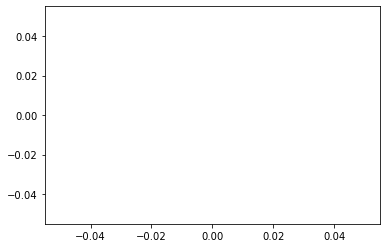

In [23]:
from fastai.vision.widgets import plt

xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]

# @audit 🛑 : WTF is the plotted graph just BLANK?? Why is accs empty?
plt.plot(xs, accs)
accs

--- @audit KEY TAKE AWAYS --- 

[MODEL] - not just domain split between vision, nlp ..etc

A model is defined by :

- (x) independent variable
- (y) dependent variable
- (loss function) MNIST, SGD, BCE ...etc

This ^ view allows for models like :

- (GPT) text(x)  => text(y)
- (SD)  text(x)  => image(y)
- (CV)  image(y) => text(y) // also audio/waves are essentially images too

[DATABLOCK API]
Understanding the DataBlock API is [KEY] to :
- moving beyond FIXED applications
- CRAFTING novel solutions to novel problems


--- IMAGE REGRESSION ---

[HEAD POSE]

Key Point center of a person's face is a good target for a regression model
This means we are predicting 2 values for each image:
1) x (row) coordinate of the center of the face
2) y (column) cooridnate of the center of the face

In [24]:
# get head pose data
path_head_pose = untar_data(URLs.BIWI_HEAD_POSE)
print(f'--[found this many biwi head pose files : {len(path_head_pose.ls())}]--\n{path_head_pose.ls()}') # type:ignore

--[found this many biwi head pose files : 51]--
[Path('/Users/mton/.fastai/data/biwi_head_pose/io_sample.cpp'), Path('/Users/mton/.fastai/data/biwi_head_pose/07.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/13.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/03'), Path('/Users/mton/.fastai/data/biwi_head_pose/04'), Path('/Users/mton/.fastai/data/biwi_head_pose/12.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/06.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/10.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/04.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/05'), Path('/Users/mton/.fastai/data/biwi_head_pose/02'), Path('/Users/mton/.fastai/data/biwi_head_pose/05.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/11.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/15.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/01.obj'), Path('/Users/mton/.fastai/data/biwi_head_pose/.DS_Store'), Path('/Users/mton/.fastai/data/biwi_head_pose/14.obj'), Path(

In [25]:
# subdirectories are different frames : an image (_rgb.jpg) and a pose file (_pose.txt)
(path_head_pose/'01').ls() # type: ignore
print(f'{str(x)[:-7]}pose.txt')

TensorImage([[[[-1.6042, -1.5014, -1.7069,  ..., -0.8507, -0.9705, -0.9534],
               [-1.5699, -1.5870, -1.6727,  ..., -1.0733, -1.0562, -0.7650],
               [-1.4500, -1.4843, -1.4672,  ..., -1.1589, -0.8164, -0.8678],
               ...,
               [-1.1247, -1.1418, -1.0904,  ...,  0.1768,  0.1254,  0.0398],
               [-1.1589, -1.1418, -1.0733,  ...,  0.1254,  0.0227,  0.0912],
               [-1.1932, -1.1589, -1.0733,  ...,  0.1939,  0.1254,  0.0741]],

              [[-1.4230, -1.2829, -1.5105,  ..., -1.2654, -1.2654, -0.8627],
               [-1.3704, -1.2654, -1.4930,  ..., -1.3179, -1.0378, -0.3725],
               [-1.2479, -1.1253, -1.1078,  ..., -1.1954, -0.3901, -0.2500],
               ...,
               [-0.9503, -0.9678, -0.9153,  ...,  0.3452,  0.2927,  0.2227],
               [-1.0028, -0.9853, -0.9153,  ...,  0.2752,  0.1877,  0.2752],
               [-1.0553, -1.0203, -0.9328,  ...,  0.3452,  0.2927,  0.2752]],

              [[-1.4384, -1.3513

In [26]:
from fastai.vision.data import get_image_files, Path

# recursively get all image files
img_files = get_image_files(path_head_pose)

# return pose file for the given image file
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

print(f'--[image]--\n{img_files[0]}\n--[pose]--\n{img2pose(img_files[0])}')

--[image]--
/Users/mton/.fastai/data/biwi_head_pose/03/frame_00393_rgb.jpg
--[pose]--
/Users/mton/.fastai/data/biwi_head_pose/03/frame_00393_pose.txt


image resolution (source) : (480, 640)


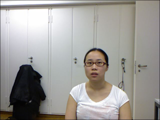

In [27]:
from fastai.vision.core import PILImage

img = PILImage.create(img_files[0]) #type: ignore
print(f'image resolution (source) : {img.shape}') # type: ignore
img.to_thumb(160) # type: ignore


In [28]:
path_head_pose/'01'/'rgb.cal'

Path('/Users/mton/.fastai/data/biwi_head_pose/01/rgb.cal')

In [29]:
from fastai.vision.data import np, tensor

# Gets center coordinates of face from pose file, return as a tensor of 2 values
def get_ctr(f):
    cal = np.genfromtxt(path_head_pose/'01'/'rgb.cal', skip_footer=6)
    # print(f'[cal] : \n{cal}')
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    # print(f'[ctr] : {ctr}')
    # print(f'[c1] = ctr[0] {ctr[0]} + cal[0][0] {cal[0][0]} / ctr[2] {ctr[2]} + cal[0][2] {cal[0][2]}')
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    # print(f'[c2] = ctr[1] {ctr[1]} + cal[1][1] {cal[1][1]} / ctr[2] {ctr[2]} + cal[1][2] {cal[1][2]}')
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    # print(f'return [c1] {c1} and [c2] {c2}')
    return tensor([c1, c2])

In [30]:
get_ctr(img_files[0])

tensor([387.1024, 261.9126])

In [31]:
from fastai.vision.data import ImageBlock, PointBlock, FuncSplitter
from fastai.vision.augment import aug_transforms, Normalize
from fastai.vision.core import imagenet_stats

biwi = DataBlock(
    # @note PointBlock indicates that the labels represent coordinates, fastai
    # applies the same augmentation to these coordinates as well as the images
    # Fastai has this built in, other libraries may not implementations :
    # - will manually implement augmenting the labels
    # - not do any augmentation at all on the image, else drift will occur
    # - because PointBlock is the dependent variable, MSELoss is the default
    #   loss function since that commonly measures DISTANCE
    blocks=(ImageBlock, PointBlock), # type: ignore
    get_items=get_image_files,
    get_y=get_ctr,
    # We can't use random_splitter because the images are NOT independent, the
    # same people appear in multiple images, and we want to make sure the model
    # generalizes to the people that it hasn't seen yet
    # Instead, we'll use a function that splits the data based on the parent
    # directory name, because each folder contains a set of frames for a single
    # person id : 
    # - Our function will return TRUE for just that one person, resulting in a 
    #   validation set with just that person's images
    # @audit-ok 🔎 : Explain why o.parent.name=='13' is inlined/hardcoded
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[
        *aug_transforms(size=(240,320)),
        Normalize.from_stats(*imagenet_stats)
    ]
)

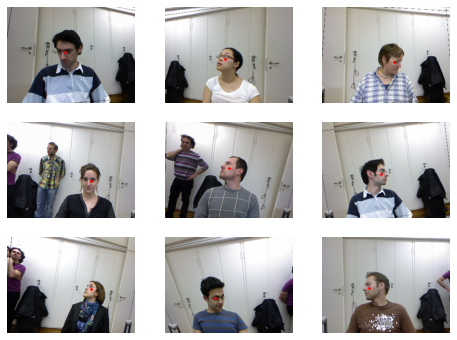

In [32]:
dls = biwi.dataloaders(path_head_pose)
# confirm that visually data are looking ok
dls.show_batch(max_n=9, figsize=(8,6))

In [33]:
xb, yb = dls.one_batch()
# also check the underlying tensor to clarify what model is seeing
xb.shape, yb.shape
# @audit-ok 🔎 : explain why the shape is (torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [34]:
# Looking at a row from the dependent variable, we haven't used a separate 
# image regression model, we have only specified how to retrieve the dependent
# variable from the data
yb[0]

TensorPoint([[0.1083, 0.2251]])

In [35]:
# @audit-ok ☑ :The y_range is last component needed to train our model as 
# opposed to just retrieving the dependent variable (yb) from the data
# - coordinates in fastai and pytorch are rescaled to be between -1 and 1
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# y_range is implemented in fastai as a sigmoid_range function
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo

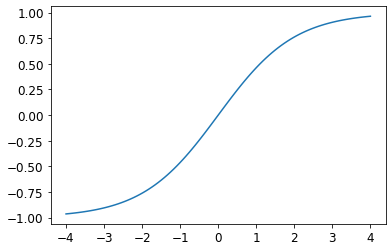

In [37]:
from fastbook import plot_function

# @audit-ok 🔎 : Explain why are we using partial sigmoid_range
# Confirm if PointBlock is uv coordinate, where 0,0 is the center of the image
# if so we are normalizing the position of the face center to be between -1 and 1
plot_function(partial(sigmoid_range, lo=-1, hi=1), min=-4, max=4)

In [38]:
# no loss function specified,let's see what was defaulted to by fastai
# FlattenedLoss of MSELoss()
# - Because coordinates are the dependent variable, most of the time we want to
#   measuere DISTANCE between the predicted and actual coordinates
# - @note MSELoss is the most common loss function for measuring DISTANCE
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=6.30957365501672e-05)

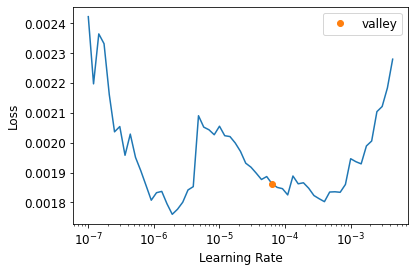

In [43]:
# find a good learning rate
# @note ⚠️ : learn.lr_find() ~ 10 minutes
learn.lr_find()

In [44]:
lr= 6.30957365501672e-05
# @note ⚠️ : learn.lr_fine_tune(3, l4) ~ 90 minutes
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.001800,0.000176,1.000000,30:48
1,0.001696,0.000094,1.000000,30:21
2,0.001636,0.000254,1.000000,30:24


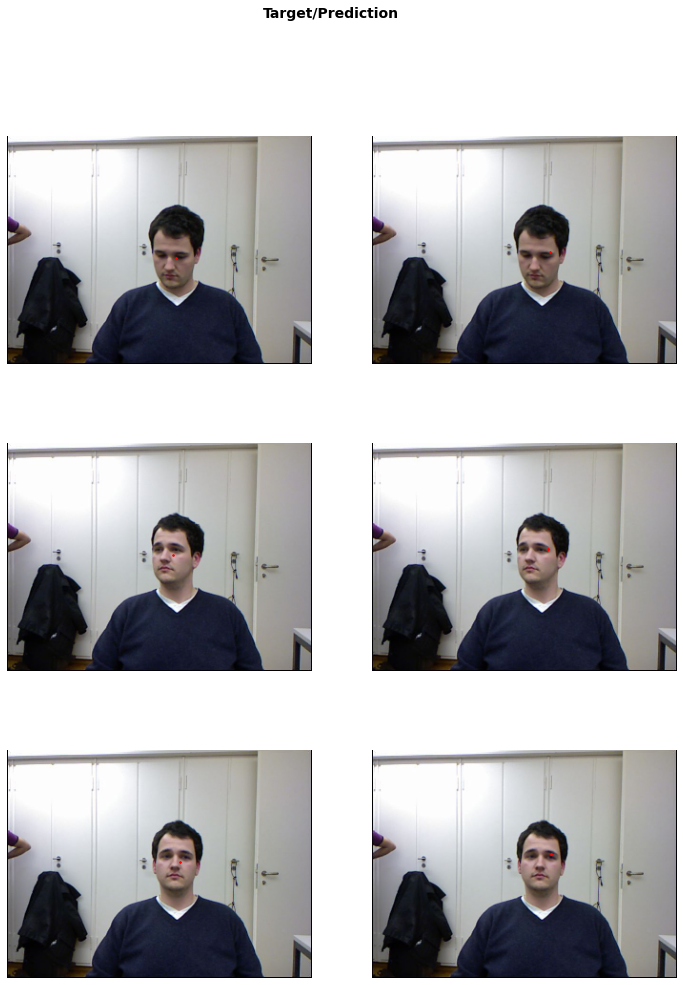

In [41]:
# Show results : left side is ground truth, right side is prediction
# @audit-ok 🔎 : Explain how we are able to show ground truth and prediction
learn.show_results(ds_idx=1, max_n=3, figsize=(12, 16))

--- CONCLUSION ---

In problems that are at first glance completely different :

- single label classification
- multi label classification
- regression

We end up using the SAME model with DIFFERENT outputs and the 
@audit LOSS function is the ONE thing that CHANGES

Which is WHY it's important to DOUBLE check the LOSS function